# Discriminator Model Performance

This notebook is designed to analyze the discriminator model's performance. Once the generative model labels our data, the discriminator model takes those labels and improves on predictions. For this notebook we are using a generative model trained on Disease associates Gene label functions to predict Disease associates Gene sentences. Performance for each model is reported in area under the receiver operating curve (AUROC) and area under the precision recall curve (AUPR).

In [1]:
import glob
import os
import pandas as pd

import seaborn as sns
import plotnine as p9
import scipy.stats as ss
from sklearn.metrics import auc, precision_recall_curve, roc_curve, precision_recall_fscore_support

# Tune Set

## Performance of Disc model vs Gen model for each Label Sample

In [2]:
dev_labels = pd.read_csv("input/dag_dev_labels.tsv", sep="\t")
dev_labels.head()

,candidate_id,curated_dsh
0,21841,1.0
1,82680,0.0
2,177856,1.0
3,228511,1.0
4,235056,1.0


In [3]:
candidate_df = (
    pd.read_excel("../data/sentences/sentence_labels_dev.xlsx")
    .sort_values("candidate_id")
    .query("curated_dsh.notnull()")
)
candidate_df.head()

,candidate_id,disease,gene,doid_id,entrez_gene_id,sentence_id,sentence,curated_dsh,notes_dsh,curated_dug,notes_dug,curated_ddg,notes_ddg,Unnamed: 13
510,21841,hypertension,beta-hydroxylase,DOID:10763,1621,482597,the decrease of sympathetic activity by the be...,1.0,NaN,0.0,NaN,0.0,The drug decreases gene expression not the dis...,NaN
949,82680,AS),HLA B27),DOID:7147,3106,1291564,"a study was made , in co-operation with severa...",0.0,NaN,0.0,NaN,0.0,NaN,NaN
567,177856,systemic lupus erythematosus,thrombin,DOID:9074,2147,2106040,it is thought to reflect increased ~~[[2 throm...,1.0,NaN,0.0,NaN,0.0,NaN,NaN
0,228511,AML,TNF alpha,DOID:2531,7124,3355574,"however , addition of anti-tnf alpha ( every 7...",1.0,NaN,1.0,NaN,0.0,NaN,NaN
529,235056,major depression,5HT1A),DOID:1595,3350,2946297,"gepirone , a selective serotonin ( ~~[[2 5ht1a...",1.0,NaN,0.0,NaN,0.0,NaN,NaN


In [4]:
gen_model_results_dev_df = pd.read_csv(
    "../label_sampling_experiment/results/DaG/results/dev_sampled_results.tsv", 
    sep="\t"
)

In [5]:
disc_model_dict = {}

for value in gen_model_results_dev_df.lf_num.unique():
        
    disc_model_dict[value] = (
        pd.read_csv(f"input/disc_model_run/{value}/tune.tsv", sep="\t")
    )

In [6]:
def get_au_performance(predictions, gold_labels):
    fpr, tpr, _ = roc_curve(
        gold_labels,
        predictions
    )
    
    precision, recall, _ = precision_recall_curve(
        gold_labels,
        predictions
    )
    
    return auc(fpr, tpr), auc(recall, precision)

In [7]:
records = []
for sample in disc_model_dict:
        for column in disc_model_dict[sample].drop("candidate_id", axis=1).columns:
            aucs = get_au_performance(
                disc_model_dict[sample][column], 
                candidate_df
                .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
                .curated_dsh
                .values
            )
            records.append({
                "model": "disc_model",
                "lf_num": int(sample),
                "auroc": aucs[0],
                "aupr": aucs[1]
            })

dev_set_df = (
    pd.DataFrame.from_records(records)
    .append(
        gen_model_results_dev_df
        .drop("lf_sample", axis=1)
        .assign(model="gen_model")
    )
)

In [8]:
dev_set_stats_df = (
    dev_set_df
    .groupby(["lf_num", "model"])
    .agg({
    "auroc": ['mean', 'std'],
    "aupr": ['mean', 'std'],
    "lf_num": len
    })
    .reset_index()
    .fillna(0)
)
dev_set_stats_df.columns = [
    "_".join(col) 
    if col[1] != '' and col[0] not in ['hetionet', 'gene_symbol', 'doid_name', 'split'] else col[0] 
    for col in dev_set_stats_df.columns.values
]

critical_val = ss.norm.ppf(0.975)

dev_set_stats_df = (
    dev_set_stats_df
    .assign(
        **{
            'auroc_upper': lambda x: x.auroc_mean + (critical_val * x.auroc_std)/pd.np.sqrt(x.lf_num_len),
            'auroc_lower': lambda x: x.auroc_mean - (critical_val * x.auroc_std)/pd.np.sqrt(x.lf_num_len),
            'aupr_upper': lambda x: x.aupr_mean + (critical_val * x.aupr_std)/pd.np.sqrt(x.lf_num_len),
            'aupr_lower':lambda x: x.aupr_mean - (critical_val * x.aupr_std)/pd.np.sqrt(x.lf_num_len)
        }
    )
)
dev_set_stats_df

,lf_num,model,auroc_mean,auroc_std,aupr_mean,aupr_std,lf_num_len,auroc_upper,auroc_lower,aupr_upper,aupr_lower
0,0,disc_model,0.488990,0.000000,0.441982,0.000000,1,0.488990,0.488990,0.441982,0.441982
1,0,gen_model,0.494070,0.000000,0.422810,0.000000,1,0.494070,0.494070,0.422810,0.422810
2,1,disc_model,0.544990,0.007937,0.454841,0.005863,50,0.547190,0.542790,0.456466,0.453216
3,1,gen_model,0.502480,0.010091,0.431385,0.010464,50,0.505277,0.499683,0.434285,0.428484
4,6,disc_model,0.590447,0.039985,0.513701,0.045574,50,0.601530,0.579364,0.526333,0.501069
5,6,gen_model,0.557170,0.026302,0.474297,0.028517,50,0.564461,0.549880,0.482201,0.466393
6,11,disc_model,0.643062,0.049617,0.572458,0.056580,50,0.656814,0.629309,0.588141,0.556775
7,11,gen_model,0.594267,0.030374,0.500662,0.031746,50,0.602686,0.585848,0.509462,0.491863
8,16,disc_model,0.680709,0.041371,0.611157,0.053273,50,0.692176,0.669242,0.625924,0.596391
9,16,gen_model,0.617423,0.028242,0.514108,0.029960,50,0.625251,0.609595,0.522412,0.505804


/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


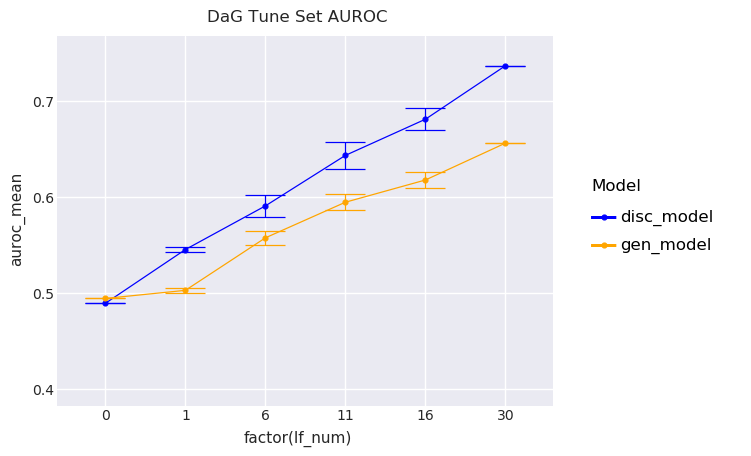

<ggplot: (8730953887208)>

In [9]:
(
    p9.ggplot(dev_set_stats_df, p9.aes(x="factor(lf_num)", y="auroc_mean", color="model"))
    + p9.geom_point()
    + p9.geom_line(p9.aes(group="model"))
    + p9.geom_errorbar(p9.aes(ymin="auroc_lower", ymax="auroc_upper", group="model"))
    + p9.theme_seaborn()
    + p9.labs(
        title= "DaG Tune Set AUROC",
        color="Model"
    )
    + p9.scale_color_manual({
        "disc_model": "blue",
        "gen_model": "orange"
    })
    + p9.scale_y_continuous(limits=[0.4, 0.75])
)

/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


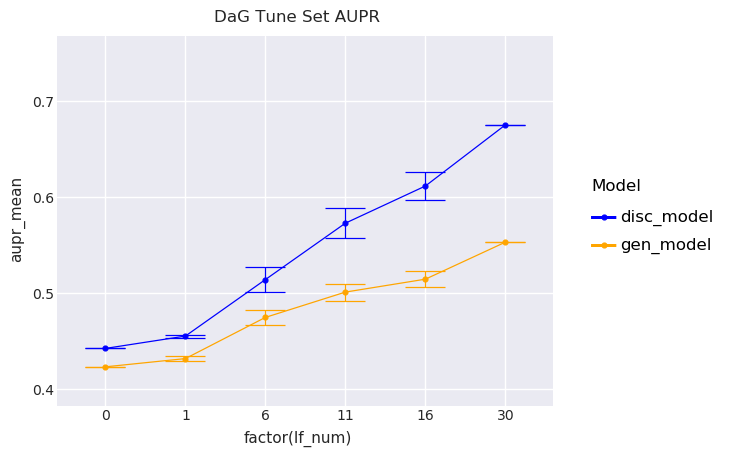

<ggplot: (-9223363305900921891)>

In [10]:
(
    p9.ggplot(dev_set_stats_df, p9.aes(x="factor(lf_num)", y="aupr_mean", color="model"))
    + p9.geom_point()
    + p9.geom_line(p9.aes(group="model"))
    + p9.geom_errorbar(p9.aes(ymin="aupr_lower", ymax="aupr_upper", group="model"))
    + p9.theme_seaborn()
    + p9.labs(
        title= "DaG Tune Set AUPR",
        color="Model"
    )
    + p9.scale_color_manual({
        "disc_model": "blue",
        "gen_model": "orange"
    })
    + p9.scale_y_continuous(limits=[0.4, 0.75])
)

In [11]:
dev_set_df.to_csv("output/dev_set_disc_performance.tsv", index=False, sep="\t")

##  Precision-Recall Improvement over Generative Model

In [12]:
gen_predicton = (
    pd.read_csv(
        "../label_sampling_experiment/results/DaG/marginals/tune/30_sampled_dev.tsv",
        sep="\t"
    )
    .assign(candidate_id=candidate_df.candidate_id.values.tolist())
    .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
    .iloc[:,0]
)

In [13]:
disc_precision, disc_recall, _ = precision_recall_curve(
    candidate_df
    .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
    .curated_dsh
    .values, 
    disc_model_dict[30]['0']
)

gen_precision, gen_recall, _ = precision_recall_curve(
    candidate_df
    .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
    .curated_dsh
    .values,
    gen_predicton
)

In [14]:
pr_perform_df = (
    pd.DataFrame(
        {'precision':gen_precision, 'recall':gen_recall}
    )
    .assign(model='gen_model')
    .append(
        pd.DataFrame(
            {'precision':disc_precision, 'recall':disc_recall}
        )
        .assign(model='disc_model')
    )
)

/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


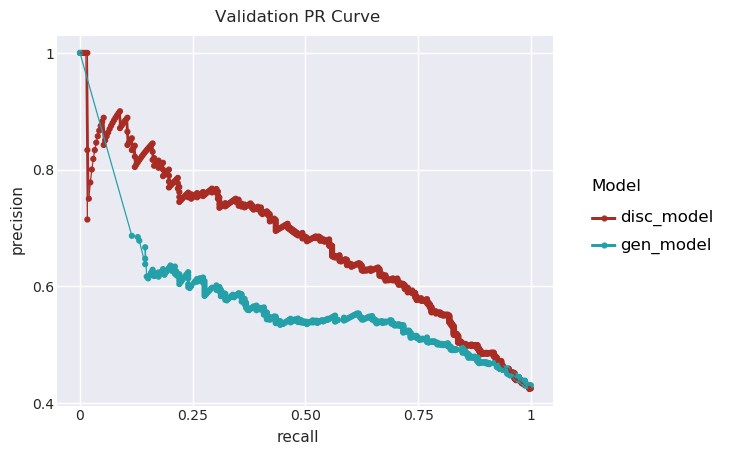

<ggplot: (-9223363305900930104)>

In [15]:
(
    p9.ggplot(pr_perform_df, p9.aes(x="recall", y="precision", color="factor(model)")) +
    p9.geom_point()+ 
    p9.geom_line() + 
    p9.labs(
        title= "Validation PR Curve",
        color="Model"
    )+
    p9.scale_color_discrete(l=.4)+
    p9.theme_seaborn()
)

In [16]:
precision_recall_fscore_support(
    candidate_df
    .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
    .curated_dsh
    .values, 
    gen_predicton.apply(lambda x: 1 if x > 0.5 else 0),
    average='binary'
)

(0.4784172661870504, 0.875, 0.6186046511627906, None)

In [17]:
precision_recall_fscore_support(
    candidate_df
    .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
    .curated_dsh
    .values, 
    disc_model_dict[30]['0'].apply(lambda x: 1 if x > 0.5 else 0),
    average='binary'
)

(0.48484848484848486, 0.8947368421052632, 0.6289017341040462, None)

In [18]:
pr_perform_df.to_csv("output/dev_set_pr_performance.tsv", sep="\t", index=False)

# Test Set

## Performance of Disc model vs Gen model for each Label Sample

In [19]:
test_labels = pd.read_csv("input/dag_test_labels.tsv", sep="\t")
test_labels.head()

,candidate_id,curated_dsh
0,23356,0.0
1,23367,1.0
2,23820,1.0
3,24815,0.0
4,80484,0.0


In [20]:
candidate_df = (
    pd.read_excel("../data/sentences/sentence_labels_test.xlsx")
    .sort_values("candidate_id")
    .query("curated_dsh.notnull()")
)
candidate_df.head()

,candidate_id,disease,gene,doid_id,entrez_gene_id,sentence,curated_dsh,notes_dsh,curated_dug,notes_dug,curated_ddg,notes_ddg
0,23356,extrinsic asthma,ACTH),DOID:2841,5443,hypothalamic-pituitary-adrenal function in a w...,0.0,NaN,0.0,NaN,0.0,NaN
1,23367,RA,GGTP,DOID:7148,92086,the values for ~~[[2 ggtp 2]]~~ were significa...,1.0,NaN,1.0,NaN,0.0,NaN
2,23820,hepatitis B,eAg),DOID:2043,3756,"a family of antigens , referred to collectivel...",1.0,NaN,0.0,NaN,0.0,NaN
3,24815,hepatoma,Mitochondrial ATPase,DOID:3571,514,~~[[2 mitochondrial atpase 2]]~~ activities of...,0.0,NaN,0.0,NaN,0.0,NaN
4,80484,hypertensive,fibrinogen,DOID:10763,2244,"the blood pressure , the plasma renin activity...",0.0,NaN,0.0,NaN,0.0,NaN


In [21]:
gen_model_results_test_df = pd.read_csv(
    "../label_sampling_experiment/results/DaG/results/test_sampled_results.tsv", 
    sep="\t"
)

In [22]:
disc_model_dict = {}

for value in gen_model_results_test_df.lf_num.unique():

    disc_model_dict[value] = (
        pd.read_csv(f"input/disc_model_run/{value}/test.tsv", sep="\t")
    )

In [23]:
records = []
for sample in disc_model_dict:
        for column in disc_model_dict[sample].drop("candidate_id", axis=1).columns:
            aucs = get_au_performance(
                disc_model_dict[sample][column], 
                candidate_df
                .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
                .curated_dsh
                .values
            )
            records.append({
                "model": "disc_model",
                "lf_num": int(sample),
                "auroc": aucs[0],
                "aupr": aucs[1]
            })

test_set_df = (
    pd.DataFrame.from_records(records)
    .append(
        gen_model_results_test_df
        .drop("lf_sample", axis=1)
        .assign(model="gen_model")
    )
)

In [24]:
test_set_stats_df = (
    test_set_df
    .groupby(["lf_num", "model"])
    .agg({
    "auroc": ['mean', 'std'],
    "aupr": ['mean', 'std'],
    "lf_num": len
    })
    .reset_index()
    .fillna(0)
)
test_set_stats_df.columns = [
    "_".join(col) 
    if col[1] != '' and col[0] not in ['hetionet', 'gene_symbol', 'doid_name', 'split'] else col[0] 
    for col in test_set_stats_df.columns.values
]

critical_val = ss.norm.ppf(0.975)

test_set_stats_df = (
    test_set_stats_df
    .assign(
        **{
            'auroc_upper': lambda x: x.auroc_mean + (critical_val * x.auroc_std)/pd.np.sqrt(x.lf_num_len),
            'auroc_lower': lambda x: x.auroc_mean - (critical_val * x.auroc_std)/pd.np.sqrt(x.lf_num_len),
            'aupr_upper': lambda x: x.aupr_mean + (critical_val * x.aupr_std)/pd.np.sqrt(x.lf_num_len),
            'aupr_lower':lambda x: x.aupr_mean - (critical_val * x.aupr_std)/pd.np.sqrt(x.lf_num_len)
        }
    )
)
test_set_stats_df

,lf_num,model,auroc_mean,auroc_std,aupr_mean,aupr_std,lf_num_len,auroc_upper,auroc_lower,aupr_upper,aupr_lower
0,0,disc_model,0.565748,0.000000,0.455269,0.000000,1,0.565748,0.565748,0.455269,0.455269
1,0,gen_model,0.571414,0.000000,0.434471,0.000000,1,0.571414,0.571414,0.434471,0.434471
2,1,disc_model,0.556329,0.005265,0.418315,0.009031,50,0.557789,0.554870,0.420818,0.415811
3,1,gen_model,0.573495,0.005757,0.433342,0.008444,50,0.575091,0.571900,0.435682,0.431001
4,6,disc_model,0.602681,0.028509,0.461379,0.027995,50,0.610584,0.594779,0.469138,0.453619
5,6,gen_model,0.586933,0.019953,0.442085,0.020246,50,0.592464,0.581402,0.447697,0.436473
6,11,disc_model,0.625183,0.028391,0.473549,0.029291,50,0.633052,0.617314,0.481667,0.465430
7,11,gen_model,0.596157,0.022813,0.443595,0.022454,50,0.602480,0.589833,0.449818,0.437371
8,16,disc_model,0.640360,0.025323,0.485647,0.027364,50,0.647379,0.633341,0.493232,0.478062
9,16,gen_model,0.602583,0.014914,0.440699,0.015235,50,0.606717,0.598449,0.444922,0.436477


/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


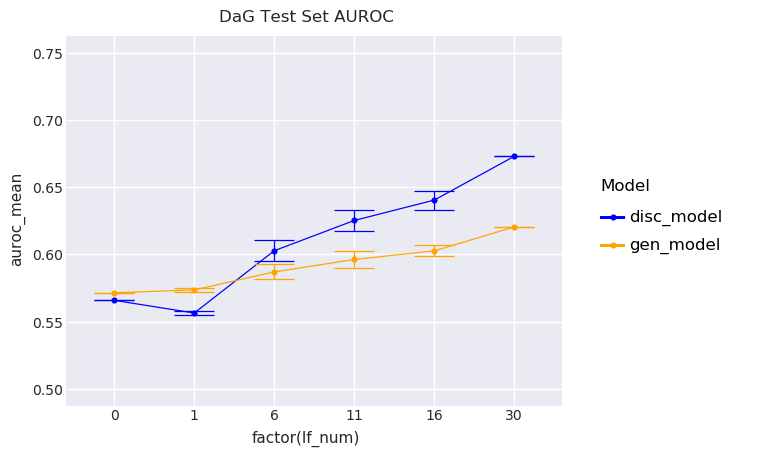

<ggplot: (-9223363305901186791)>

In [25]:
(
    p9.ggplot(test_set_stats_df, p9.aes(x="factor(lf_num)", y="auroc_mean", color="model"))
    + p9.geom_point()
    + p9.geom_line(p9.aes(group="model"))
    + p9.geom_errorbar(p9.aes(ymin="auroc_lower", ymax="auroc_upper", group="model"))
    + p9.theme_seaborn()
    + p9.labs(
        title= "DaG Test Set AUROC",
        color="Model"
    )
    + p9.scale_color_manual({
        "disc_model": "blue",
        "gen_model": "orange"
    })
    + p9.scale_y_continuous(limits=[0.5, 0.75])
)

/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


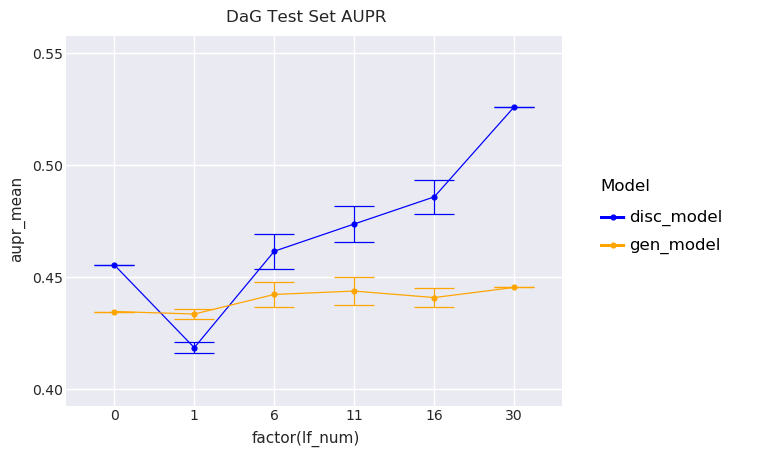

<ggplot: (8730953588344)>

In [26]:
(
    p9.ggplot(test_set_stats_df, p9.aes(x="factor(lf_num)", y="aupr_mean", color="model"))
    + p9.geom_point()
    + p9.geom_line(p9.aes(group="model"))
    + p9.geom_errorbar(p9.aes(ymin="aupr_lower", ymax="aupr_upper", group="model"))
    + p9.theme_seaborn()
    + p9.labs(
        title= "DaG Test Set AUPR",
        color="Model"
    )
    + p9.scale_color_manual({
        "disc_model": "blue",
        "gen_model": "orange"
    })
    + p9.scale_y_continuous(limits=[0.4, 0.55])
)

In [27]:
test_set_df.to_csv("output/test_set_disc_performance.tsv", index=False, sep="\t")

##  Precision-Recall Improvement over Generative Model

In [28]:
gen_predicton = (
    pd.read_csv(
        "../label_sampling_experiment/results/DaG/marginals/test/30_sampled_test.tsv",
        sep="\t"
    )
    .assign(candidate_id=candidate_df.candidate_id.values.tolist())
    .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
    .iloc[:,0]
)

In [29]:
disc_precision, disc_recall, _ = precision_recall_curve(
    candidate_df
    .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
    .curated_dsh
    .values, 
    disc_model_dict[30]['0']
)

gen_precision, gen_recall, _ = precision_recall_curve(
    candidate_df
    .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
    .curated_dsh
    .values,
    gen_predicton
)

In [30]:
pr_perform_df = (
    pd.DataFrame(
        {'precision':gen_precision, 'recall':gen_recall}
    )
    .assign(model='gen_model')
    .append(
        pd.DataFrame(
            {'precision':disc_precision, 'recall':disc_recall}
        )
        .assign(model='disc_model')
    )
)

/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


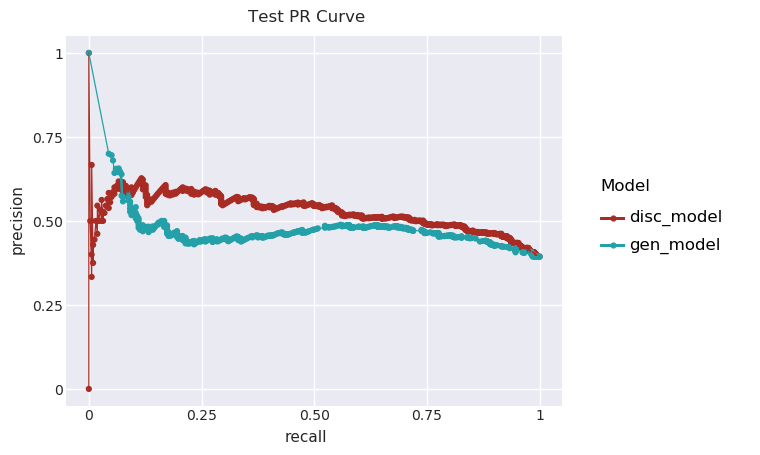

<ggplot: (8730953459278)>

In [31]:
(
    p9.ggplot(pr_perform_df, p9.aes(x="recall", y="precision", color="factor(model)")) +
    p9.geom_point()+ 
    p9.geom_line() + 
    p9.labs(
        title= "Test PR Curve",
        color="Model"
    )+
    p9.scale_color_discrete(l=.4)+
    p9.theme_seaborn()
)

In [32]:
precision_recall_fscore_support(
    candidate_df
    .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
    .curated_dsh
    .values, 
    gen_predicton.apply(lambda x: 1 if x > 0.5 else 0),
    average='binary'
)

(0.4540441176470588, 0.7791798107255521, 0.5737514518002322, None)

In [33]:
precision_recall_fscore_support(
    candidate_df
    .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
    .curated_dsh
    .values, 
    disc_model_dict[30]['0'].apply(lambda x: 1 if x > 0.5 else 0),
    average='binary'
)

(0.4833948339483395, 0.8264984227129337, 0.6100116414435389, None)

In [34]:
pr_perform_df.to_csv("output/test_set_pr_performance.tsv", sep="\t", index=False)